# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [21]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [22]:
df = pd.read_csv('../data/checker_submits.csv')

In [23]:
# Преобразование временной метки
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

# Выбор нужных колонок
df = df[['uid', 'labname', 'numTrials', 'hour', 'dayofweek']]

In [24]:
# One-Hot Encoding для категориальных признаков
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['uid', 'labname']]).toarray()
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['uid', 'labname']))

# Удаление исходных категориальных колонок и добавление закодированных
df = df.drop(columns=['uid', 'labname'])
df = pd.concat([df, encoded_df], axis=1)

In [25]:
# Масштабирование числовых признаков
scaler = StandardScaler()
df[['numTrials', 'hour']] = scaler.fit_transform(df[['numTrials', 'hour']])

# Сохранение данных
df.to_csv('../data/dayofweek.csv', index=False)

In [26]:
# Наивный алгоритм
naive_prediction = df['dayofweek'].mode()[0]
naive_accuracy = accuracy_score(df['dayofweek'], [naive_prediction] * len(df))
print(f'Naive algorithm accuracy: {naive_accuracy}')

Naive algorithm accuracy: 0.23487544483985764


## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [27]:
# Разделение данных
X = df.drop(columns=['dayofweek'])
y = df['dayofweek']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Логистическая регрессия
logreg = LogisticRegression(random_state=21, fit_intercept=False, max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, max_iter=1000, random_state=21)

In [28]:
# Точность
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
print(f'Logistic Regression accuracy: {logreg_accuracy}')

Logistic Regression accuracy: 0.6538461538461539


In [29]:
# Функция для построения графика
def plot_feature_importances(coef, names, top_n=10):
    imp = coef
    imp, names = zip(*sorted(zip(imp, names), key=lambda x: abs(x[0]), reverse=True))
    plt.barh(range(top_n), imp[:top_n], align='center')
    plt.yticks(range(top_n), names[:top_n])
    plt.show()

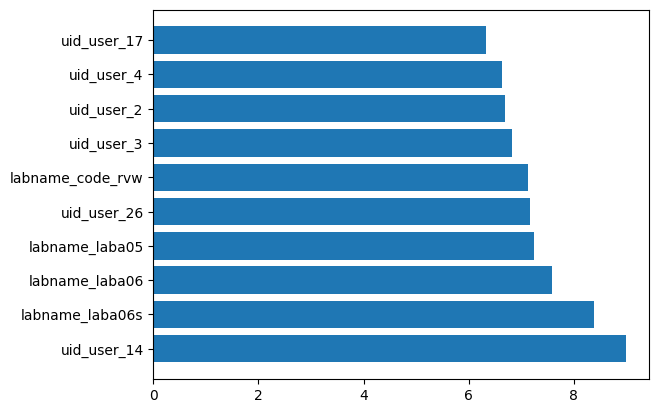

In [30]:
# Построение графика для логистической регрессии
coef = logreg.coef_
feature_importance = np.sum(np.abs(coef), axis=0)
plot_feature_importances(feature_importance, X.columns, top_n=10)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [31]:
svc = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=21))
svc.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(kernel='linear', probability=True,
                                  random_state=21))

In [32]:
# Точность
svc_accuracy = accuracy_score(y_test, svc.predict(X_test))
print(f'SVC accuracy: {svc_accuracy}')

SVC accuracy: 0.6331360946745562


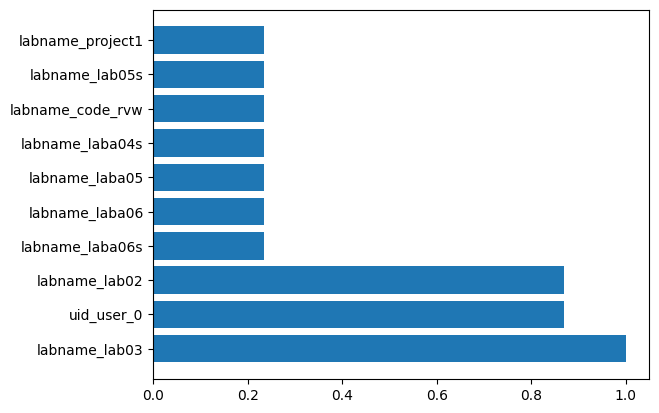

In [33]:
# Построение графика для SVC
# Получение коэффициентов из базового классификатора
coef = svc.estimators_[0].coef_
# Вычисление важности признаков
feature_importance = np.sum(np.abs(coef), axis=0)

plot_feature_importances(feature_importance, X.columns, top_n=10)

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [34]:
# Дерево решений
tree = DecisionTreeClassifier(max_depth=4, random_state=21)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=21)

In [35]:
# Точность
tree_accuracy = accuracy_score(y_test, tree.predict(X_test))
print(f'Decision Tree accuracy: {tree_accuracy}')

Decision Tree accuracy: 0.5562130177514792


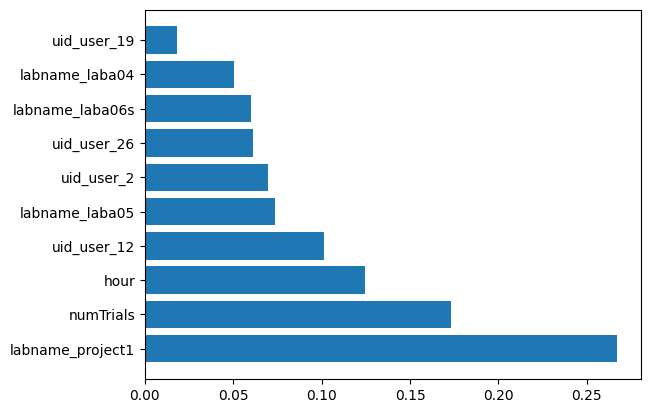

In [36]:
# Построение графика для дерева решений
plot_feature_importances(tree.feature_importances_, X.columns, top_n=10)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [37]:
# Случайный лес
rf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, random_state=21)

In [38]:
# Точность
rf_accuracy = accuracy_score(y_test, rf.predict(X_test))
print(f'Random Forest accuracy: {rf_accuracy}')

Random Forest accuracy: 0.9467455621301775


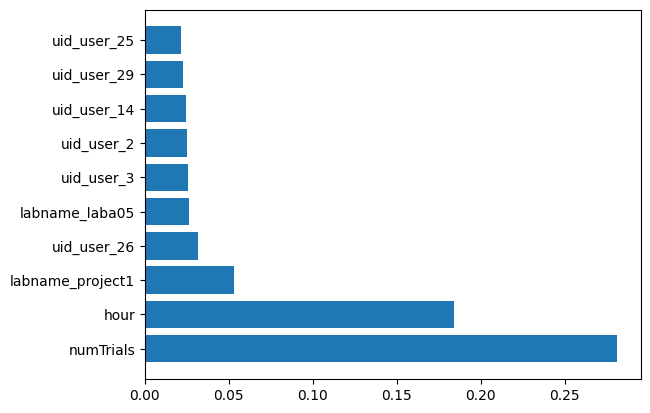

In [39]:
# Построение графика для случайного леса
plot_feature_importances(rf.feature_importances_, X.columns, top_n=10)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   numTrials         1686 non-null   float64
 1   hour              1686 non-null   float64
 2   dayofweek         1686 non-null   int32  
 3   uid_user_0        1686 non-null   float64
 4   uid_user_1        1686 non-null   float64
 5   uid_user_10       1686 non-null   float64
 6   uid_user_11       1686 non-null   float64
 7   uid_user_12       1686 non-null   float64
 8   uid_user_13       1686 non-null   float64
 9   uid_user_14       1686 non-null   float64
 10  uid_user_15       1686 non-null   float64
 11  uid_user_16       1686 non-null   float64
 12  uid_user_17       1686 non-null   float64
 13  uid_user_18       1686 non-null   float64
 14  uid_user_19       1686 non-null   float64
 15  uid_user_2        1686 non-null   float64
 16  uid_user_20       1686 non-null   float64
